# HW3

### Random Data Generator

- univariate gaussian data

- polynomial basis linear model

### Sqeuential estimate the mean and variance

### Baysian Linear regression

In [1]:
import math
import random
import matplotlib.pyplot as plt
from IPython.display import Latex, Markdown, Pretty
import pandas as pd
import numpy as np

In [2]:
def Mean(x):
    return sum(x) / len(x)

def Variance(x):
    u = Mean(x)
    return sum([(i - u)**2 for i in x]) / len(x)
    
def Covariance(x, y):
    ux = Mean(x)
    uy = Mean(y)
    return sum([(x[i] - ux)*(y[i] - uy) for i in range(len(x))]) / len(x)

class mylogging():
    def __init__(self, output=False, nolog=False):
        self.logs = ""
        self.output = output
        self.nolog = nolog
    
    def info(self, s):
        if self.output:
            print(s)
        if not self.nolog:
            self.logs += s + "\n"

### Random Data Generator

#### univariate gaussian data

- INPUT : expectation value $u$, variance $\sigma^2$
- OUTPUT : one outcome

all outcome will distribute like $N(u,\sigma^2)$

##### Marsaglia polar method

$$ \\
-1 \underline{<} U , V \underline{<} 1, S = U^2+V^2 \\
X = U\sqrt{\frac{-2\ln S}{S}}, Y = V\sqrt{\frac{-2\ln S}{S}}, when \space S < 1
$$

In [3]:
def Marsaglia():
    while True:
        U = random.random()*2-1
        V = random.random()*2-1
        if (U**2)+(V**2) < 1:
            break
    
    S = (U**2)+(V**2)
    S = math.sqrt((-2*math.log(S))/S)
    return (U*S, V*S)

def GaussianDataGenerator(u, v):
    sigma = math.sqrt(v)
    while True:
        D1, D2 = Marsaglia()
        yield u + sigma*D1
        yield u + sigma*D2

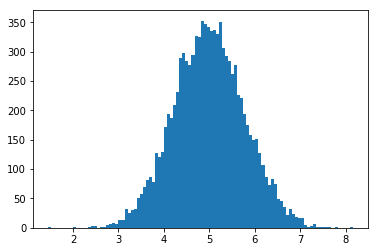

[4.994873342829168, 0.6028041993300499]

In [4]:
GDG = GaussianDataGenerator(5, 0.6)

Gdatas = [next(GDG) for _ in range(10000)]

plt.hist(Gdatas, 100)
plt.show()
[Mean(Gdatas), Variance(Gdatas)]

#### polynomial basis linear model

$$ y=w^TPhi(x)+e;e \sim N(0,\sigma^2) \\
w^TPhi(x) = \sum_{i}^{n} w_ix^i
$$

- INPUT : error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- OUTPUT : one data point $(x,y)$
- NOTE : $ -10.0 < x < 10.0 $

In [5]:
def Gaussian(u, v):
    return lambda x : (math.exp(-1*(((x - u)**2) / (2*v) ) ) / math.sqrt(2*math.pi*v))

def Polynomial(w):
    return lambda x : sum([w[i]*(x**i) for i in range(len(w))])

def PolynomialDataGenerator(n, v, w, x_constrain=(-10,10)):
    if len(w) != n:
        raise TypeError("length of w need equal n, {}!={}".format(len(w), n))
    e = GaussianDataGenerator(u=0,v=v)
    phi = Polynomial(w)
    x_range = abs(x_constrain[0] - x_constrain[1])
    while True:
        x = random.random()*x_range - (x_range/2)
        y = phi(x) + next(e)
        yield (x, y)

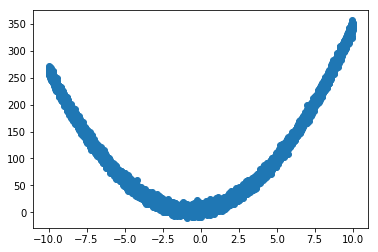

In [6]:
dg = PolynomialDataGenerator(3, 25, [5, 4, 3])
tmp = [next(dg) for _ in range(10000)]
x = [item[0] for item in tmp]
y = [item[1] for item in tmp]

plt.scatter(x, y)
plt.show()

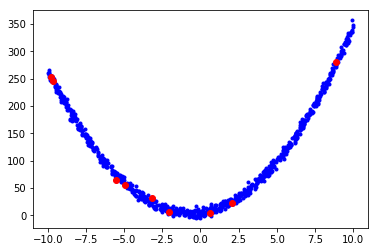

CPU times: user 28.9 s, sys: 21.9 s, total: 50.8 s
Wall time: 17.2 s


In [7]:
%%time
from IPython.display import clear_output
import time 
dg = PolynomialDataGenerator(n=3,v=10000,w=[0,1,0.01])
point_count = 1000
show_per_count = 10
data_x = []
data_y = []
show_x = []
show_y = []
for datapoint in tmp:
    x, y = datapoint
    
    if point_count % show_per_count == 0:
        plt.plot(data_x, data_y, 'b.')
        plt.plot(show_x, show_y, 'ro')
        plt.show()
        #time.sleep(0.5)
        data_x += show_x
        show_x = []
        data_y += show_y
        show_y = []
    else:
        show_x.append(x)
        show_y.append(y)
    
    point_count -= 1
    if point_count == 0:
        break;
    if point_count % show_per_count == 0:
        clear_output(wait=True)

### Sqeuential estimate the mean and variance

- INPUT : expectation value $u$, variance $\sigma^2$
- FUNCTION : find cureent estimates, repeat until the estimates converge
- OUTPUT : print new data point and cureent estimates each iteration

In [8]:
def NaiveEstimate():
    u = 0
    v = 1
    n = 0
    data_sum = 0
    data_sum2 = 0
    while True:
        new_data = (yield (u, v))
        n += 1
        data_sum += new_data
        data_sum2 += new_data**2
        u = data_sum / n
        v = (data_sum2 / n) - (u**2)

def SqeuentialEstimate(dg, es=NaiveEstimate):
    current_u = 0
    current_v = 1
    es = es()
    current_u, current_v = next(es)
    while True:
        new_data = next(dg)
        current_u, current_v = es.send(new_data)
        yield (new_data, current_u, current_v)

In [12]:
def test_SqeuentialEstimate(u, v, converge_threshold = 10**-2, times=1, max_iter=10000, output=False, output_rate = 1):
    iter_counts = []
    dg = GaussianDataGenerator(u, v)
    mylog = mylogging(output)
    
    while times != 0:
        iter_count = 0
        se = SqeuentialEstimate(dg)
        prev_u = None
        prev_v = None
        test_over = False
        
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for estimate in se:
            iter_count += 1
            new_data, next_u, next_v = estimate
            
            if prev_u != None and prev_v != None:
                if abs(next_u - prev_u) <= converge_threshold and abs(next_v - prev_v) <= converge_threshold:
                    test_over = True

            if iter_count > max_iter and max_iter != -1:
                test_over = True;
            
            if (iter_count-1) % output_rate == 0 or test_over:
                mylog.info("[{:5d}] new data : {:.3f}\tcurrent(u,v):({:.3f}, {:.3f})".format(
                    iter_count,
                    new_data,
                    next_u,
                    next_v,))
            
            if test_over:
                break;
            
            prev_u = next_u
            prev_v = next_v
                
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

In [13]:
_, logs = test_SqeuentialEstimate(5, 0.6, times=2, output_rate=10)
Pretty(logs)


==========Test Start==========

[    1] new data : 6.176	current(u,v):(6.176, 0.000)
[   11] new data : 4.827	current(u,v):(5.151, 0.702)
[   21] new data : 3.144	current(u,v):(4.990, 0.695)
[   31] new data : 6.223	current(u,v):(5.166, 0.715)
[   41] new data : 4.347	current(u,v):(5.146, 0.607)
[   51] new data : 3.739	current(u,v):(5.066, 0.587)
[   54] new data : 5.417	current(u,v):(5.043, 0.579)

==========Test   End==========


==========Test Start==========

[    1] new data : 4.499	current(u,v):(4.499, 0.000)
[   11] new data : 5.669	current(u,v):(4.884, 0.707)
[   21] new data : 3.963	current(u,v):(4.869, 0.640)
[   31] new data : 6.464	current(u,v):(4.909, 0.600)
[   41] new data : 4.188	current(u,v):(4.920, 0.519)
[   50] new data : 5.331	current(u,v):(4.974, 0.563)

==========Test   End==========



In [14]:
%%time
test_outputs,_ = test_SqeuentialEstimate(5, 0.6, times=1000)

CPU times: user 7.49 s, sys: 11.1 s, total: 18.6 s
Wall time: 18.6 s


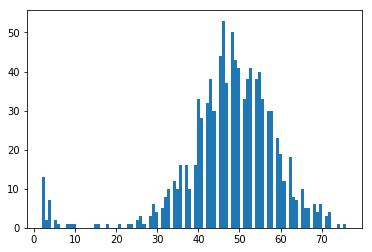

In [15]:
plt.hist(test_outputs, 100)
plt.show()

### Baysian Linear regression

- INPUT : for inital prior $\sim N(0, b^{-1}I)$ parameter $b$, error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- FUNCTION : gen one data point and update prior and calculate the predictive distribution, repeat until the posterior converges
- OUTPUT : print the new data point and the current parameter for posterior and predictive distribution

$$\\
k : datapoints \space numbers \\
S^{-1} : prior \space covariance \space matrix , n*n\\
m : prior \space mean \space vector, n*1\\
X : design \space matrix, k*n \\
y_{pred} = Xw + error, k*1 \\
posterior_b = aX^TX + S = aX^TX + prior_b\\
w = posterior_u = posterior_b^{-1}(aX^Ty + Sm) = posterior_b^{-1}(aX^Ty + (prior_b)(prior_u)) \\
$$

#### Predictive distribution

$$ P(Y|\theta) = \int P(Y|w, \theta)P(w, \theta) \sim dw \\
P(Y|w, \theta) \sim N(Y|Xw, a^{-1}) \\
P(w, \theta) = Prior \sim N(W|u, b^{-1}) \\
P(Y|\theta) \sim N(Xw, a^{-1} + XbX^T) \\
$$

In [16]:
from MatrixOP import *
from Polynomial import *

In [17]:
def Design_Matrix(datas, N):
    # create matrix
    Design_X = [];
    Target_y = [];
    
    if type(datas) != list:
        datas = [datas]

    for index, row in enumerate(datas):
        x,y = row
        Design_X.append([basis(x, i) for i in range(N)])
        Target_y.append([y])
    
    return (Design_X,Target_y)

In [18]:
def BaysianLinearRegression(dataGenerator, likelihood_a, prior_u, prior_b):
    n = len(prior_u)
    input_u = prior_u
    input_b = prior_b
    
    
    while True:
        new_data = next(dataGenerator)
        X,y = Design_Matrix(new_data,n)
        
        # b' = aX^TX + b
        posterior_b = mul_matrix_scalar(likelihood_a, mul_matrix(tranpose_matrix(X), X))
        posterior_b = add_matrix(posterior_b, prior_b)
        # u' = b'^-1(aX^Ty + bu)
        posterior_u = add_matrix(mul_matrix_scalar(likelihood_a ,mul_matrix(tranpose_matrix(X), y)), mul_matrix(prior_b, prior_u))
        posterior_u = mul_matrix(inverse_matrix(posterior_b), posterior_u)
        
        reset = yield (new_data, posterior_u, posterior_b)

        if reset == True:
            prior_u = input_u
            prior_b = input_b
            yield (prior_u, prior_b)
        else:
            prior_u = posterior_u
            prior_b = posterior_b

In [33]:
def Design_X(xs, n):
    if type(xs) != list:
        xs = list(x)
    return [[basis(x,i) for i in range(n)] for x in xs]
    
def PredictiveDistribution(a, w, b):
    n = len(w)
    b_i = inverse_matrix(b)
    return lambda x: (mul_matrix(Design_X(x,n),w), add_matrix_scalar((1/a), mul_matrix(mul_matrix(Design_X(x,n), b_i), tranpose_matrix(Design_X(x,n)))) )

def ShowPredictiveDistribution(a, w, b, plotline, datas, new_data=None):
    if type(datas) != dict:
        raise TypeError("Type of datas must be hash : {}".format(str(type(datas))))
    if type(plotline) != dict:
        raise TypeError("Type of plotline must be hash : {}".format(str(type(plotline))))
    
    ypd = PredictiveDistribution(a, w, b)
    predict_y, predict_covar = ypd(plotline['x'])
    predict_y = [y[0] for y in predict_y]
    predict_var = [predict_covar[i][i] for i in range(len(predict_covar))]
    predict_var = [math.sqrt(v) for v in predict_var]
    
    clear_output(wait=True)
    plt.plot([plotline['x'],plotline['x']],[list(map(lambda x:x[0]-x[1], zip(predict_y,predict_var))), list(map(lambda x:x[0]+x[1], zip(predict_y,predict_var)))], 'r', linewidth=0.1)
    plt.plot(datas['x'], datas['y'], 'bo', markerfacecolor='none')
    if new_data:
        plt.plot(new_data['x'], new_data['y'], 'yo', markerfacecolor='none')
    plt.plot(plotline['x'], plotline['y'], 'g', label='target')
    plt.plot(plotline['x'], predict_y, 'r', label='predict')
    #plt.plot(plotline['x'], [predict.f(x) for x in plotline['x']], 'r', label='predict')
    plt.ylim((-2,2))
    plt.legend()
                    
    plt.show()

In [47]:
def test_BaysianLinearRegression(
        BLR, 
        target_equation=None, 
        converge_threshold=10**-3, 
        times=1, 
        max_iter=10000, 
        output=False, 
        output_rate=1,
        x_contrain=(-10,10)):
    
    iter_counts = []
    plot_x = list(np.linspace(x_contrain[0], x_contrain[1], 500))
    
    if target_equation:
        target_y = [target_equation.f(x) for x in plot_x];
    else:
        target_y = None
    mylog = mylogging(output, False)
    
    
    
    while times != 0:
        iter_count = 0
        data_x = []
        data_y = []
        test_over = False;
        
        # reset BLR
        next(BLR)
        prev_u, prev_b = BLR.send(True)
    
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for regression in BLR:
            iter_count += 1
            x,y = regression[0]
            u = regression[1]
            b = regression[2]
            predict = polynomial_equation(u)
            
            
            # converge check
            All_converge = True
            distance_u = sub_matrix(u, prev_u)
            distance_b = sub_matrix(b, prev_b)
            for rows in distance_u:
                for item in rows:
                    if abs(item) > converge_threshold:
                        All_converge = False
                        break;
                
                if not All_converge:
                    break;
                
            if All_converge:
                test_over = True
                
            if iter_count >= max_iter and max_iter != -1:
                test_over = True
                
            if (iter_count-1) % output_rate == 0 or test_over:
                mylog.info("[{:5d}] new data(x,y) : ({:.3f}, {:.3f})".format(iter_count, x, y))
                mylog.info("\n predictive distribution : " + str(predict) + "\n")
                
                # plot
                if target_y:
                    ShowPredictiveDistribution(10**5, u, b,{'x':plot_x,'y':target_y},{'x':data_x,'y':data_y},{'x':x,'y':y})
            
            if test_over:
                break
            
            data_x.append(x)
            data_y.append(y)
                
            prev_u = u;
            prev_b = b;
        
        
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

In [48]:
# one test data w = [0, 0, 0, 0.01]
# input parameter
error_v = 0.01
w = [0, 1, 0, -1/6,0,1/120,0,-1/5040]
n = 8

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = 1

dg = PolynomialDataGenerator(n, error_v, w, (-math.pi, math.pi))
blr = BaysianLinearRegression(dg, 1, prior_u, prior_b)
target_e = polynomial_equation(w)

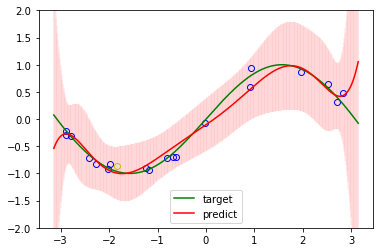

[20]
CPU times: user 40.4 s, sys: 4.89 s, total: 45.3 s
Wall time: 37.6 s


In [49]:
%%time
outcomes, logs = test_BaysianLinearRegression(blr, target_e,converge_threshold=10**-6,times=1, max_iter=20, output_rate=1, x_contrain=(-math.pi, math.pi))
print(outcomes)
Markdown(logs)

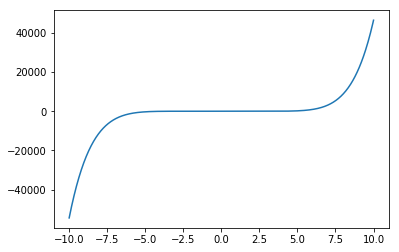

$$y = +0.01x^7-0.00x^6-0.07x^5+0.02x^4+0.15x^3+0.04x^2+0.67x^1-0.14$$

In [40]:
_, predict_w, _ = next(blr) 
predict_distribution = polynomial_equation(predict_w)
x = np.linspace(-10,10,1000)
plt.plot(x, [predict_distribution.f(i) for i in x])
plt.show()
Markdown(str(predict_distribution))

In [51]:
_, prior_w, prior_b = next(blr)
ypd = PredictiveDistribution(likelihood_a, prior_w, prior_b)

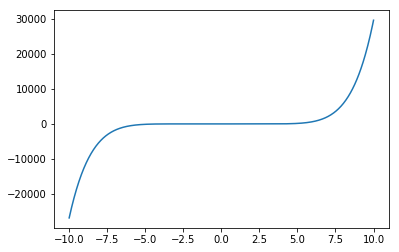

In [52]:
x = np.linspace(-10,10,1000)
y,covar = ypd(x)
y =[item[0] for item in y]
plt.plot(x,y)

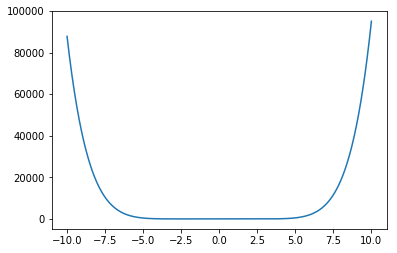

In [53]:
var = [covar[i][i] for i in range(len(covar))]
var = [math.sqrt(v) for v in var]
plt.plot(x, var)

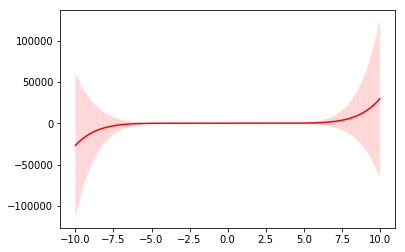

In [54]:
plt.plot([x,x],[list(map(lambda x:x[0]-x[1], zip(y,var))), list(map(lambda x:x[0]+x[1], zip(y,var)))], 'r', linewidth=0.05)
plt.plot(x,y,'r')
plt.show()

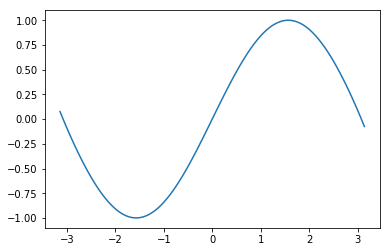

In [55]:
x = np.linspace(math.pi,-math.pi,100)
plt.plot(x, [target_e.f(i) for i in x])